<h1>ЦПТ для различных распределений</h1>

<h3>Сгенерируйте примеры из распределения</h3>

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import math
import random
%matplotlib inline

In [97]:
anglit_rv = sts.anglit(0,100)
sample = anglit_rv.rvs(10000)
real_mean = anglit_rv.mean()
real_var = anglit_rv.var()
print(real_mean)
print(real_var)

0.0
1168.5027506808487


<h3>Постройте гистограмму выборки и теоретическую плотность распределения</h3>

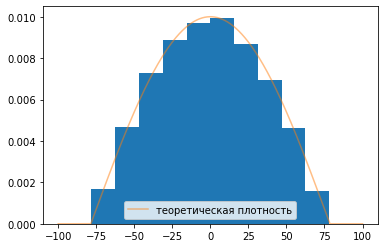

In [101]:

plt.hist(sample, density=True)
x = np.linspace(-100,100,10000)
pdf = anglit_rv.pdf(x)
plt.plot(x, pdf, label='теоретическая плотность', alpha=0.5)
plt.legend()

In [95]:
sample_mean = sample.mean() 
print(sample_mean)
sample_var = sample.var()
print(sample_var)

-0.014899148519930776
11.142912432069442


<h3>Оценим распределение выборочного среднего для разных объёмов выборок</h3>

Для этого постройте на одном полотне гистограмму выборочных средних и теоретическое распределение выборочных средних по ЦПТ для разных объёмов выборок.

Для теоретического распределение используйте настоящие значения мат ожидания и дисперсии (не приближенные на основе выборки).

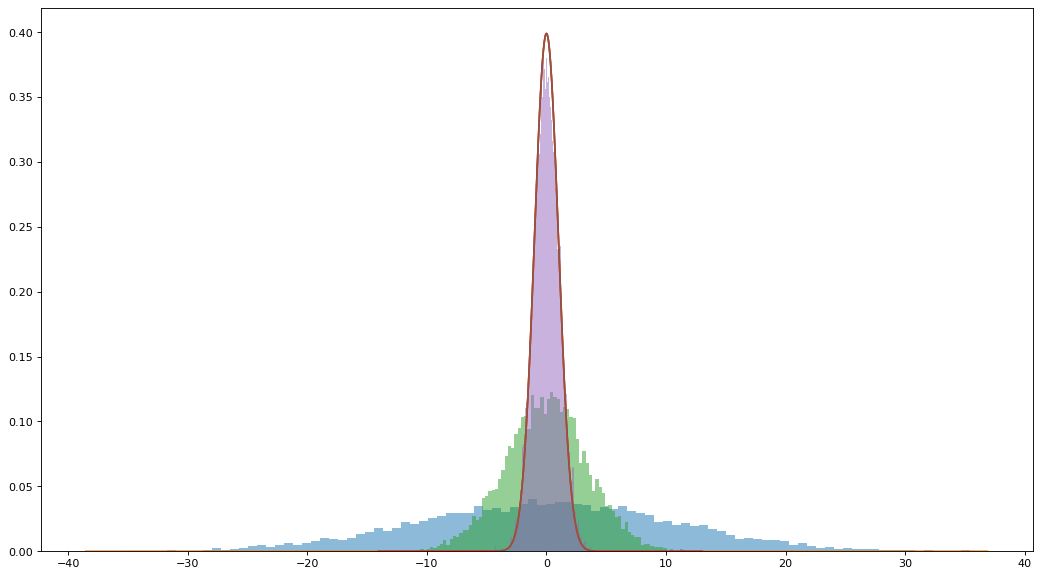

In [393]:
from statistics import mean

fig, axes = plt.subplots(figsize=(16,9), dpi=80)
x = np.linspace(-100,100,500)
for N in [10,100,1000]:
    means = []
    for i in range(10000):
         means.append(np.mean(anglit_rv.rvs(N)))
    plt.hist(means, alpha=0.5, bins=100, density=True)
    pdf_norm = sts.norm.pdf(np.sort(means))
    plt.plot(np.sort(means),pdf_norm)
plt.show()

Как вы считаете, для выбранного распределения апроксимация распределения выборочного среднего работает хорошо или плохо?

На графике видно, что с увеличением объема выборки среднее выборочное значение приближается к реальному матожиданию распределения (0). Распределение похоже на нормальное, начиная уже с небольшого объема выборки (N=10). Для выбранного типа распределения апроксимация работает хорошо.

<H2>Доверительный интервал на основе ЦПТ</H2>

Возьмите данные для оттока телеком компании, и постройте доверительные интервалы для среднего значения total day calls, используя центральную предельную теорему в разбиении по колонке churn (ушел/не ушел).

Для оценки дисперсии используйте несмещенную оценку (параметр ddof=1).

Сделайте оценку с использованием явной формулы для z интервала, а затем с помощью функций from statsmodels.stats.weightstats import _zconfint_generic. Сравните результаты.

Ссылка на данные: https://drive.google.com/file/d/1X_drKqoarnU2Sz2har7uSCsgyhh8Xtz8/view?usp=sharing

In [183]:
url ="https://raw.githubusercontent.com/piton1/DS/Lesson_5/telecom_churn.csv"
df=pd.read_csv(url)
display(df)

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,...,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,...,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,...,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,...,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


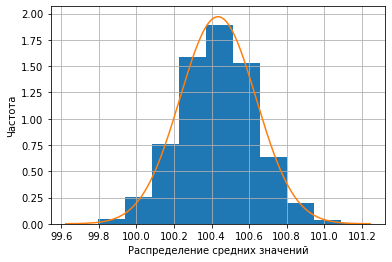

(100.43395181518149, 0.04102500874595383)

In [356]:
N=10000 #объем выборки

def bootstrap(xs, n, replace=True):
    '''Вернуть список массивов меньших размеров 
    по n элементов каждый'''
    return np.random.choice(xs, (len(xs), n), replace=replace) 

v=df['total day calls'].tolist()
means = pd.Series(map(np.mean, bootstrap(v, N)))
means.hist(density=True)
plt.xlabel('Распределение средних значений') 
plt.ylabel('Частота')

#соответствующее нормальное распределение
mu = means.mean()
variance = means.var(ddof=1)
sigma = math.sqrt(variance)
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
plt.plot(x, sts.norm.pdf(x, mu, sigma))
plt.show()
mu, variance

In [386]:

#доверительный интервал для ушедших
leave=df.loc[df['churn']==True]['total day calls'].tolist()
alpha = 0.05
std_val = np.std(leave,ddof=1)
lower = np.mean(leave)+sts.norm.ppf(alpha/2)*(std_val/(len(leave)**0.5))
upper = np.mean(leave)+sts.norm.ppf(1-alpha/2)*(std_val/(len(leave)**0.5))
lower,upper

(99.41066229112079, 103.26014516229537)

In [387]:
#с помощью функции для ушедших
from statsmodels.stats.weightstats import _zconfint_generic
_zconfint_generic(np.mean(leave),np.std(leave,ddof=1),1-alpha,'two-sided')

(99.98204678079553, 102.68876067262063)

In [388]:
#доверительный интервал для оставшихся
stay=df.loc[df['churn']==False]['total day calls'].tolist()
alpha = 0.05
std_val = np.std(stay,ddof=1)
lower = np.mean(stay)+sts.norm.ppf(alpha/2)*(std_val/(len(stay)**0.5))
upper = np.mean(stay)+sts.norm.ppf(1-alpha/2)*(std_val/(len(stay)**0.5))
lower,upper

(99.55618833318324, 101.01012745629045)

In [389]:
#с помощью функции для оставшихся
from statsmodels.stats.weightstats import _zconfint_generic
_zconfint_generic(np.mean(stay),np.std(stay,ddof=1),1-alpha,'two-sided')

(99.04149114274126, 101.52482464673243)

Коэффициент корреляции показателей churn и totals day calls:

0.018459311608576907


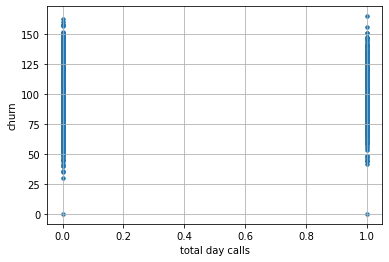

In [391]:
pd.DataFrame(np.array([df['churn'],df['total day calls']]).T).plot.scatter(0, 1, s=12, grid=True)
plt.xlabel('total day calls')
plt.ylabel('churn')
print(df['churn'].corr(df['total day calls']))
plt.show()

Видим пересекающиеся диапазоны доверительних интервалов для клиентов, принявших решение уйти, и для клиентов, принявших решение остаться. Из этого можем сделать вывод о том, что информации в поле total day calls недостаточно для оценки вероятности потери клиента. Это подтверждается и маленьким коэффициентом корреляции для данных показателей.